In [1]:
import numpy as np
from pathlib import Path
import os
import matplotlib.pyplot as plt
import pandas as pd

from vestibular_vr_pipeline.harp import process, utils
from vestibular_vr_pipeline.sleap import load_and_process as lp

In [2]:
data_path = Path('/home/ikharitonov/RANCZLAB-NAS/data/ONIX/20240730_Mismatch_Experiment/training_day4/2024-08-02T12-25-55_B3M3')
photometry_path = Path('/home/ikharitonov/RANCZLAB-NAS/data/ONIX/20240730_Mismatch_Experiment/training_day4/photometry/B3M3_20240801_training_4/2024_08_02-14_28_27')

In [ ]:
# lp.create_flipped_videos(data_path, what_to_flip='VideoData1')

In [3]:
VideoData1, VideoData2 = lp.load_videography_data(data_path)

INFO:
load_and_process.load_videography_data() function expects the following format of SLEAP outputs:
"VideoData1_1904-01-01T00-00-00.sleap.csv"
"VideoData1_1904-01-01T23-59-59.sleap.csv"
"..."
Please make sure to rename SLEAP files if they are not already following this convention.


RESULTS:
Outputs of SLEAP found in VideoData1: False
Outputs of SLEAP found in VideoData2: True
Found .csv VideoData logs timestamped at:
- 1904-01-03T23:00:00.000000000
- 1904-01-04T00:00:00.000000000


/home/ikharitonov/code/aeon_mecha/vestibular_vr_pipeline/sleap/load_and_process.py:51: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  sorted_vd1_files = pd.to_datetime(pd.Series([x.split('_')[1].split('.')[0] for x in vd1_files])).sort_values()
/home/ikharitonov/code/aeon_mecha/vestibular_vr_pipeline/sleap/load_and_process.py:52: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  sorted_vd2_files = pd.to_datetime(pd.Series([x.split('_')[1].split('.')[0] for x in vd2_files])).sort_values()


Reading dataframes finished.
VideoData2 SLEAP output: 77906 frames registered, but 77864 rows found inside file. Filling with empty rows.


In [4]:
# SLEAP processing

VideoData2 = VideoData2.interpolate()

columns_of_interest = ['left.x','left.y','center.x','center.y','right.x','right.y','p1.x','p1.y','p2.x','p2.y','p3.x','p3.y','p4.x','p4.y','p5.x','p5.y','p6.x','p6.y','p7.x','p7.y','p8.x','p8.y']
coordinates_dict = lp.get_coordinates_dict(VideoData2, columns_of_interest)

theta = lp.find_horizontal_axis_angle(VideoData2, 'left', 'center')
center_point = lp.get_left_right_center_point(coordinates_dict)

columns_of_interest = ['left', 'right', 'center', 'p1', 'p2', 'p3', 'p4', 'p5', 'p6', 'p7', 'p8']
remformatted_coordinates_dict = lp.get_reformatted_coordinates_dict(coordinates_dict, columns_of_interest)
centered_coordinates_dict = lp.get_centered_coordinates_dict(remformatted_coordinates_dict, center_point)
rotated_coordinates_dict = lp.get_rotated_coordinates_dict(centered_coordinates_dict, theta)

columns_of_interest = ['p1', 'p2', 'p3', 'p4', 'p5', 'p6', 'p7', 'p8']
ellipse_parameters_data, ellipse_center_points_data = lp.get_fitted_ellipse_parameters(rotated_coordinates_dict, columns_of_interest)

SleapData = process.convert_arrays_to_dataframe(['Seconds', 'Ellipse.Width', 'Ellipse.Height', 'Ellipse.Angle', 'Ellipse.Center.X', 'Ellipse.Center.Y'], [VideoData2['Seconds'].values, ellipse_parameters_data[:,0], ellipse_parameters_data[:,1], ellipse_parameters_data[:,2], ellipse_center_points_data[:,0], ellipse_center_points_data[:,1]])

In [5]:
streams = utils.load_registers(data_path)

Photometry = utils.read_fluorescence(photometry_path)
OnixDigital = utils.read_onix_digital(data_path)

AlignedPhotometry = process.align_fluorescence_first_approach(Photometry, OnixDigital)

streams = process.reformat_and_add_many_streams(streams, AlignedPhotometry, 'Photometry', ['CH1-410', 'CH1-470', 'CH1-560'])
streams = process.reformat_and_add_many_streams(streams, SleapData, 'Eye Movements', ['Ellipse.Width', 'Ellipse.Height', 'Ellipse.Angle', 'Ellipse.Center.X', 'Ellipse.Center.Y'])

_ = process.get_timepoint_info(streams, print_all=True)
resampled_streams = process.pad_and_resample(streams, resampling_period='0.1ms', method='linear')
_ = process.get_timepoint_info(resampled_streams, print_all=True)

Dataset 2024-08-02T12-25-55_B3M3 contains following registers:
H1: [46, 32, 33, 38]
H2: [39, 42]
Successfully loaded.


/home/ikharitonov/code/aeon_mecha/vestibular_vr_pipeline/harp/utils.py:108: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  sorted_filenames = pd.to_datetime(pd.Series([x.split('_')[1].split('.')[0] for x in filenames])).sort_values()


Global first timestamp: 1904-01-03 23:56:06.349844
Global last timestamp: 1904-01-04 00:18:06.159233
Global length: 0 days 00:21:59.809389

H1
OpticalTrackingRead0X(46): 
	first  1904-01-03 23:56:18.930240 
	last   1904-01-04 00:17:59.250240 
	length 0 days 00:21:40.320000 
	mean difference between timestamps 0 days 00:00:00.010000
OpticalTrackingRead0Y(46): 
	first  1904-01-03 23:56:18.930240 
	last   1904-01-04 00:17:59.250240 
	length 0 days 00:21:40.320000 
	mean difference between timestamps 0 days 00:00:00.010000
OpticalTrackingRead0Brightness(46): 
	first  1904-01-03 23:56:18.930240 
	last   1904-01-04 00:17:59.250240 
	length 0 days 00:21:40.320000 
	mean difference between timestamps 0 days 00:00:00.010000
OpticalTrackingRead1X(46): 
	first  1904-01-03 23:56:18.930240 
	last   1904-01-04 00:17:59.250240 
	length 0 days 00:21:40.320000 
	mean difference between timestamps 0 days 00:00:00.010000
OpticalTrackingRead1Y(46): 
	first  1904-01-03 23:56:18.930240 
	last   1904-01-04 0

/home/ikharitonov/code/aeon_mecha/vestibular_vr_pipeline/harp/process.py:10: FutureWarning: Series.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  return data_stream_df.resample(resampling_period).last().interpolate(method=method)


Global first timestamp: 1904-01-03 23:56:06.349800
Global last timestamp: 1904-01-04 00:18:06.159200
Global length: 0 days 00:21:59.809400

H1
OpticalTrackingRead0X(46): 
	first  1904-01-03 23:56:06.349800 
	last   1904-01-04 00:18:06.159200 
	length 0 days 00:21:59.809400 
	mean difference between timestamps 0 days 00:00:00.000100
OpticalTrackingRead0Y(46): 
	first  1904-01-03 23:56:06.349800 
	last   1904-01-04 00:18:06.159200 
	length 0 days 00:21:59.809400 
	mean difference between timestamps 0 days 00:00:00.000100
OpticalTrackingRead0Brightness(46): 
	first  1904-01-03 23:56:06.349800 
	last   1904-01-04 00:18:06.159200 
	length 0 days 00:21:59.809400 
	mean difference between timestamps 0 days 00:00:00.000100
OpticalTrackingRead1X(46): 
	first  1904-01-03 23:56:06.349800 
	last   1904-01-04 00:18:06.159200 
	length 0 days 00:21:59.809400 
	mean difference between timestamps 0 days 00:00:00.000100
OpticalTrackingRead1Y(46): 
	first  1904-01-03 23:56:06.349800 
	last   1904-01-04 0

In [6]:
running = resampled_streams['H1']['OpticalTrackingRead0X(46)']
photometry = resampled_streams['Photometry']['CH1-470']
eye_movements = resampled_streams['Eye Movements']['Ellipse.Center.X']

In [7]:
def running_unit_conversion(running_array):
    resolution = 12000 # counts per inch
    inches_per_count = 1 / resolution
    meters_per_count = 0.0254 * inches_per_count
    dt = 0.01 # for OpticalTrackingRead0Y(46)
    linear_velocity = meters_per_count / dt # meters per second per count
    
    # ball_radius = 0.1 # meters 
    # angular_velocity = linear_velocity / ball_radius # radians per second per count
    # angular_velocity = angular_velocity * (180 / np.pi) # degrees per second per count
    # print(angular_velocity)

    return running_array * linear_velocity

In [8]:
running = running_unit_conversion(running) # meters per second
running *= 100 # centimeters per second

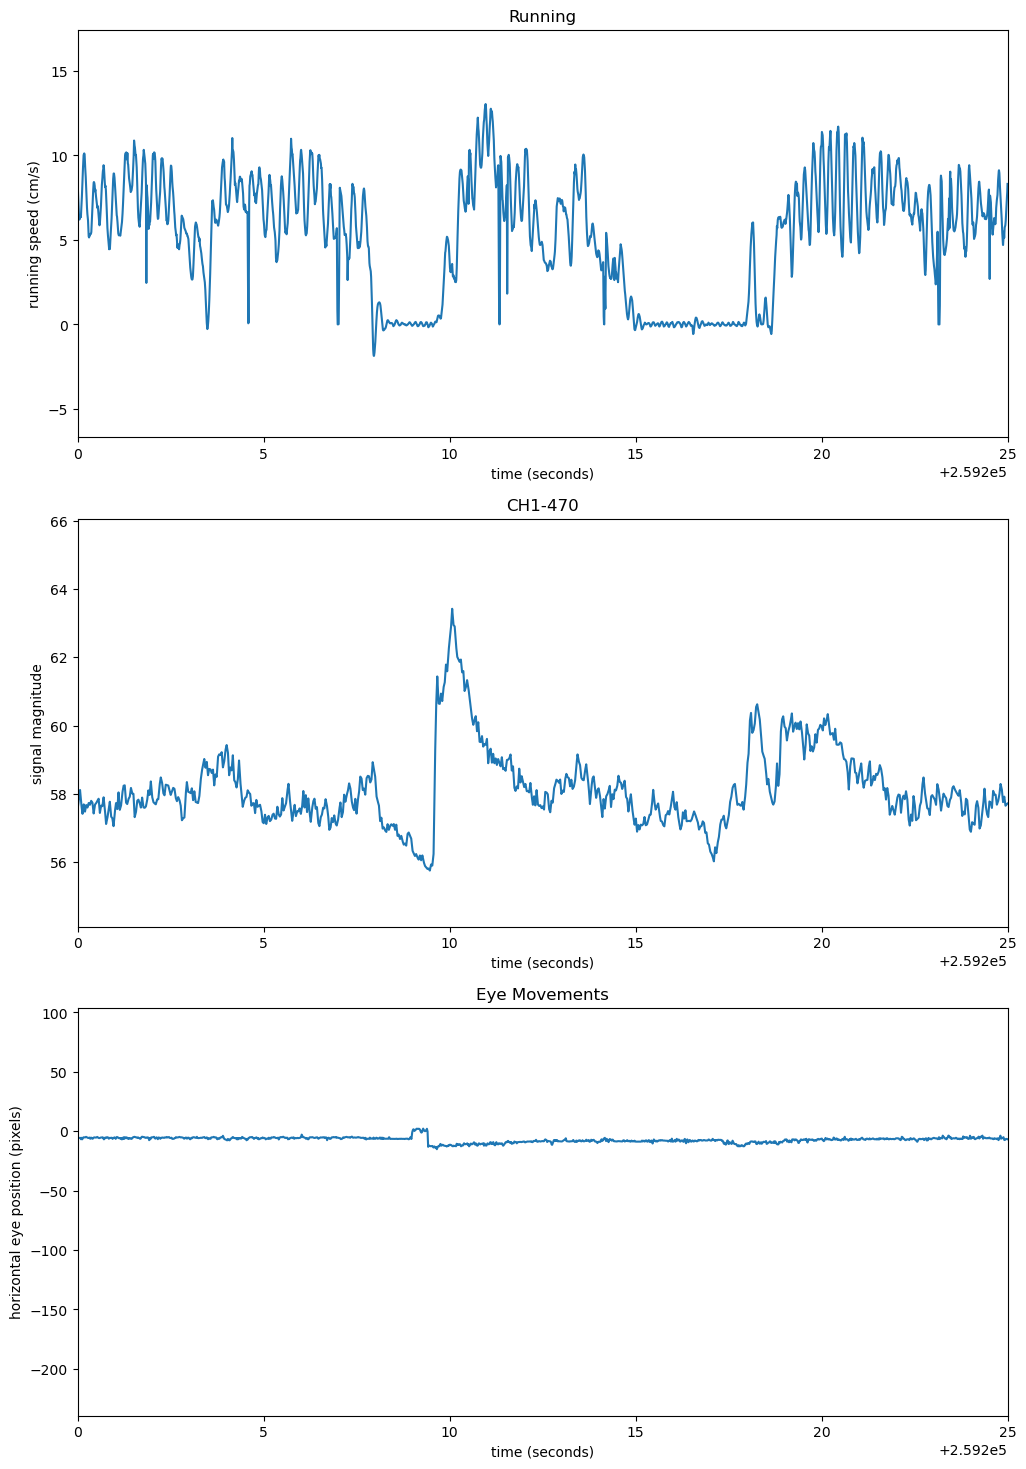

In [10]:
# A = None
# B = None
A = 259200
B = A + 25

fig, ax = plt.subplots(nrows=3, ncols=1, figsize=(12,18))

t = (running.index - utils.harp.REFERENCE_EPOCH).total_seconds()

ax[0].plot(t, running)
ax[0].set_title('Running')
ax[0].set_xlim([A,B])
ax[0].set_xlabel('time (seconds)')
ax[0].set_ylabel('running speed (cm/s)')

ax[1].plot(t, photometry)
ax[1].set_title('CH1-470')
ax[1].set_xlim([A,B])
ax[1].set_xlabel('time (seconds)')
ax[1].set_ylabel('signal magnitude')

ax[2].plot(t, eye_movements)
ax[2].set_title('Eye Movements')
ax[2].set_xlim([A,B])
ax[2].set_xlabel('time (seconds)')
ax[2].set_ylabel('horizontal eye position (pixels)')

plt.show()